# Short notebook 2 
### TDT4173 - Modern machine learning in practice - fall 2024 
Group number: 8 \
Group id kaggle: [8] Admiral P(redictor) \
Group members: André Virani(525432), Peder Aas Vårheim(564051) and Markus Sandnes(544087)

### Coding libraries 

Import the necessary coding libraries for the project

In [6]:
import pandas as pd

import numpy as np 

from datetime import timedelta 

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

### Data fetching

Before analyzing the data we have to retreive the data provided from blackboard. 

In [ ]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")
test_df = pd.read_csv('data/ais_test.csv', sep = ",")
ports_df = pd.read_csv('data/ports.csv', sep = "|")
schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = "|")
vessels_df = pd.read_csv('data/vessels.csv', sep = "|")

### Data processing

In [8]:
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId')
train_df['time'] = pd.to_datetime(train_df['time'])

test_df['time'] = pd.to_datetime(test_df['time'])
timestamps = train_df[['time', 'vesselId']]

train_df = train_df.drop(columns = ['countryName', 'ISO', 'UN_LOCODE', 'name', 'portLocation', ])

In [9]:
le_vesselid = LabelEncoder()

all_vesselId = pd.concat([train_df['vesselId'], schedules_df['vesselId']], axis = 0)

le_vesselid.fit(all_vesselId)

train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])

test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

schedules_df['vesselId'] = le_vesselid.transform(schedules_df['vesselId'])



le_shippingLineId = LabelEncoder()

all_shippingLineId = pd.concat([train_df['shippingLineId'], schedules_df['shippingLineId']], axis = 0)

le_shippingLineId.fit(all_shippingLineId)

train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])

schedules_df['shippingLineId'] = le_shippingLineId.transform(schedules_df['shippingLineId'])


le_portid = LabelEncoder()

le_portid.fit(train_df['portId'])

train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes


### Feature engineering


In [10]:
X = train_df.sort_values(by = 'vesselId', kind =  'stable')

X_1 = X.copy()

X_1[['time_x', 'longitude', 'latitude']] = (X_1[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-1))

X_1['vesselId'] = X['vesselId']

X_1['time_diff'] =  (X_1['time_x'] - X_1['time']).dt.total_seconds()

X_1 = X_1.dropna()

display(X)

display(X_1)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,portLatitude,portLongitude,shippingLineId
131115,2024-01-12 14:07:47,308.1,17.1,-6,316,0,01-08 06:00,7.50361,77.58340,0,112,13.263333,80.341111,0
131279,2024-01-12 14:31:00,307.6,17.3,5,313,0,01-14 23:30,7.57302,77.49505,0,115,18.941944,72.885278,0
131514,2024-01-12 14:57:23,306.8,16.9,5,312,0,01-14 23:30,7.65043,77.39404,0,115,18.941944,72.885278,0
131696,2024-01-12 15:18:48,307.9,16.9,6,313,0,01-14 23:30,7.71275,77.31394,0,115,18.941944,72.885278,0
131885,2024-01-12 15:39:47,307.0,16.3,7,313,0,01-14 23:30,7.77191,77.23585,0,115,18.941944,72.885278,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521244,2024-05-07 22:36:16,324.1,13.5,-2,325,0,05-08 03:00,59.63337,21.43237,699,78,60.437778,22.216389,5
1521409,2024-05-07 22:57:05,324.2,13.3,-3,326,0,05-08 03:00,59.69588,21.34225,699,78,60.437778,22.216389,5
1521625,2024-05-07 23:17:54,356.5,12.2,-1,354,0,05-08 03:00,59.76388,21.35317,699,78,60.437778,22.216389,5
1521821,2024-05-07 23:38:13,52.6,17.3,3,50,0,05-08 03:00,59.83316,21.38489,699,78,60.437778,22.216389,5


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,portLatitude,portLongitude,shippingLineId,time_x,time_diff
131115,2024-01-12 14:07:47,308.1,17.1,-6,316,0,01-08 06:00,7.57302,77.49505,0,112,13.263333,80.341111,0,2024-01-12 14:31:00,1393.0
131279,2024-01-12 14:31:00,307.6,17.3,5,313,0,01-14 23:30,7.65043,77.39404,0,115,18.941944,72.885278,0,2024-01-12 14:57:23,1583.0
131514,2024-01-12 14:57:23,306.8,16.9,5,312,0,01-14 23:30,7.71275,77.31394,0,115,18.941944,72.885278,0,2024-01-12 15:18:48,1285.0
131696,2024-01-12 15:18:48,307.9,16.9,6,313,0,01-14 23:30,7.77191,77.23585,0,115,18.941944,72.885278,0,2024-01-12 15:39:47,1259.0
131885,2024-01-12 15:39:47,307.0,16.3,7,313,0,01-14 23:30,7.81285,77.18147,0,115,18.941944,72.885278,0,2024-01-12 15:54:48,901.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521048,2024-05-07 22:15:17,296.3,14.7,3,298,0,05-08 03:00,59.63337,21.43237,699,78,60.437778,22.216389,5,2024-05-07 22:36:16,1259.0
1521244,2024-05-07 22:36:16,324.1,13.5,-2,325,0,05-08 03:00,59.69588,21.34225,699,78,60.437778,22.216389,5,2024-05-07 22:57:05,1249.0
1521409,2024-05-07 22:57:05,324.2,13.3,-3,326,0,05-08 03:00,59.76388,21.35317,699,78,60.437778,22.216389,5,2024-05-07 23:17:54,1249.0
1521625,2024-05-07 23:17:54,356.5,12.2,-1,354,0,05-08 03:00,59.83316,21.38489,699,78,60.437778,22.216389,5,2024-05-07 23:38:13,1219.0


In [11]:
X = train_df.copy()

X[['time_y', 'longitude_y', 'latitude_y']] = (X[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-1))

X['vesselId'] = X['vesselId']

X['time_diff'] =  (X['time_y'] - X['time']).dt.total_seconds()

X = X.dropna()

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

    print(k , end = '\r')

    X_k = train_df.copy()

    X_k[['time_y', 'longitude_y', 'latitude_y']] = (X_k[['time', 'vesselId', 'longitude', 'latitude']].groupby(by = 'vesselId').shift(-2**k))

    X_k['vesselId'] = train_df['vesselId']

    X_k['time_diff'] =  (X_k['time_y'] - X_k['time']).dt.total_seconds()

    X_k = X_k.dropna()

    X = pd.concat([X, X_k])



display(X)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,portLatitude,portLongitude,shippingLineId,time_y,longitude_y,latitude_y,time_diff
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,54,40,-33.587500,-71.618889,23,2024-01-01 06:09:08,-56.77210,-35.16787,22123.0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,196,674,8.967000,-79.533000,15,2024-01-01 00:33:36,-79.47938,8.89446,1980.0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,442,353,39.232500,-76.558889,14,2024-01-01 00:24:37,-76.39602,39.16657,1372.0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,117,18,-34.462500,150.899444,1,2024-01-01 01:03:14,151.02005,-34.41206,3603.0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,365,605,35.783000,-5.817000,15,2024-01-01 23:52:46,-13.93870,31.96349,85735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349749,2024-04-23 16:56:17,313.2,13.8,0,313,0,04-23 09:00,29.54633,-93.74243,492,391,29.843056,-93.961111,1,2024-05-07 22:35:55,-93.93652,29.86282,1229978.0
1349903,2024-04-23 17:16:57,333.8,13.3,0,335,0,04-23 09:00,29.60247,-93.80568,492,391,29.843056,-93.961111,1,2024-05-07 22:56:52,-93.93656,29.86288,1229995.0
1350063,2024-04-23 17:37:37,346.1,12.3,0,346,0,04-23 09:00,29.67259,-93.83260,492,391,29.843056,-93.961111,1,2024-05-07 23:17:57,-93.93647,29.86287,1230020.0
1350225,2024-04-23 17:58:08,326.8,8.6,0,326,0,04-23 09:00,29.71967,-93.86042,492,391,29.843056,-93.961111,1,2024-05-07 23:35:56,-93.93649,29.86285,1229868.0


### Feature engineering 2 

For test set 

In [12]:
display(test_df)


vessels = test_df['vesselId'].unique()

last_values = {}

for vessel in vessels:

    data_vessel = train_df[train_df['vesselId'] == vessel]

    last_values[vessel] = data_vessel.tail(1)


,ID,vesselId,time,scaling_factor
0,0,89,2024-05-08 00:03:16,0.3
1,1,635,2024-05-08 00:06:17,0.3
2,2,606,2024-05-08 00:10:02,0.3
3,3,552,2024-05-08 00:10:34,0.3
4,4,1,2024-05-08 00:12:27,0.3
...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1
51735,51735,117,2024-05-12 23:59:58,0.1
51736,51736,620,2024-05-12 23:59:58,0.1
51737,51737,584,2024-05-12 23:59:58,0.1


In [13]:
test_data = {}
for index, row in test_df.iterrows():
    print(index, end = '\r')
    last_data = last_values[row['vesselId']]
    row = pd.DataFrame(row).T    
    row = pd.merge(last_data, row, left_on='vesselId', right_on='vesselId', how='right')
    test_data[index] = row
test_data = pd.concat(test_data)

display(test_data)

,,time_x,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,portLatitude,portLongitude,shippingLineId,ID,time_y,scaling_factor
0,0,2024-05-07 23:48:16,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,89,374,31.140556,-81.496667,1,0,2024-05-08 00:03:16,0.3
1,0,2024-05-07 23:57:16,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29625,635,269,14.808333,120.279444,18,1,2024-05-08 00:06:17,0.3
2,0,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,606,130,42.098889,11.780833,21,2,2024-05-08 00:10:02,0.3
3,0,2024-05-07 23:52:34,321.3,0.1,0,70,1,05-07 01:15,-43.53785,172.83522,552,248,-43.606111,172.716111,15,3,2024-05-08 00:10:34,0.3
4,0,2024-05-07 23:51:29,291.0,0.3,0,275,2,05-09 04:00,48.53320,-6.12003,1,80,48.380556,-4.474167,25,4,2024-05-08 00:12:27,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,0,2024-04-27 21:40:48,5.7,15.6,0,10,0,05-12 20:00,26.22892,-79.40341,52,95,53.563611,8.554722,0,51734,2024-05-12 23:59:58,0.1
51735,0,2024-04-26 13:29:25,87.6,14.4,0,88,0,05-10 12:00,41.64055,143.29942,117,181,42.988611,144.353611,1,51735,2024-05-12 23:59:58,0.1
51736,0,2024-04-28 19:17:28,76.9,15.9,0,78,0,05-10 06:50,35.33234,142.69115,620,150,36.425278,140.621111,8,51736,2024-05-12 23:59:58,0.1
51737,0,2024-05-07 19:22:20,232.0,22.0,-13,234,0,05-08 19:00,59.26571,21.98971,584,102,53.952222,10.869167,22,51737,2024-05-12 23:59:58,0.1


In [14]:
test_data['time_diff'] = (pd.to_datetime(test_data['time_y']) - pd.to_datetime(test_data['time_x'])).dt.total_seconds()

display(test_data)

,,time_x,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,portLatitude,portLongitude,shippingLineId,ID,time_y,scaling_factor,time_diff
0,0,2024-05-07 23:48:16,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,89,374,31.140556,-81.496667,1,0,2024-05-08 00:03:16,0.3,900.0
1,0,2024-05-07 23:57:16,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29625,635,269,14.808333,120.279444,18,1,2024-05-08 00:06:17,0.3,541.0
2,0,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,606,130,42.098889,11.780833,21,2,2024-05-08 00:10:02,0.3,654.0
3,0,2024-05-07 23:52:34,321.3,0.1,0,70,1,05-07 01:15,-43.53785,172.83522,552,248,-43.606111,172.716111,15,3,2024-05-08 00:10:34,0.3,1080.0
4,0,2024-05-07 23:51:29,291.0,0.3,0,275,2,05-09 04:00,48.53320,-6.12003,1,80,48.380556,-4.474167,25,4,2024-05-08 00:12:27,0.3,1258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,0,2024-04-27 21:40:48,5.7,15.6,0,10,0,05-12 20:00,26.22892,-79.40341,52,95,53.563611,8.554722,0,51734,2024-05-12 23:59:58,0.1,1304350.0
51735,0,2024-04-26 13:29:25,87.6,14.4,0,88,0,05-10 12:00,41.64055,143.29942,117,181,42.988611,144.353611,1,51735,2024-05-12 23:59:58,0.1,1420233.0
51736,0,2024-04-28 19:17:28,76.9,15.9,0,78,0,05-10 06:50,35.33234,142.69115,620,150,36.425278,140.621111,8,51736,2024-05-12 23:59:58,0.1,1226550.0
51737,0,2024-05-07 19:22:20,232.0,22.0,-13,234,0,05-08 19:00,59.26571,21.98971,584,102,53.952222,10.869167,22,51737,2024-05-12 23:59:58,0.1,448658.0


In [15]:
X['time_x'] = X['time']

features1 = ['time_x', 'time_y', 'time_diff', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude', 'longitude', 'portLatitude', 'portLongitude']

features2 = ['time_x', 'time_y', 'time_diff', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude', 'longitude', 'portLatitude', 'portLongitude', 'latitude_y', 'longitude_y']



display(test_data[features1])

display(X[features2])


,,time_x,time_y,time_diff,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,portLatitude,portLongitude
0,0,2024-05-07 23:48:16,2024-05-08 00:03:16,900.0,179.6,0.0,0,344,5,05-06 10:45,31.14647,-81.49789,31.140556,-81.496667
1,0,2024-05-07 23:57:16,2024-05-08 00:06:17,541.0,24.7,0.0,0,214,5,05-01 23:00,14.81694,120.29625,14.808333,120.279444
2,0,2024-05-07 23:59:08,2024-05-08 00:10:02,654.0,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,42.098889,11.780833
3,0,2024-05-07 23:52:34,2024-05-08 00:10:34,1080.0,321.3,0.1,0,70,1,05-07 01:15,-43.53785,172.83522,-43.606111,172.716111
4,0,2024-05-07 23:51:29,2024-05-08 00:12:27,1258.0,291.0,0.3,0,275,2,05-09 04:00,48.53320,-6.12003,48.380556,-4.474167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,0,2024-04-27 21:40:48,2024-05-12 23:59:58,1304350.0,5.7,15.6,0,10,0,05-12 20:00,26.22892,-79.40341,53.563611,8.554722
51735,0,2024-04-26 13:29:25,2024-05-12 23:59:58,1420233.0,87.6,14.4,0,88,0,05-10 12:00,41.64055,143.29942,42.988611,144.353611
51736,0,2024-04-28 19:17:28,2024-05-12 23:59:58,1226550.0,76.9,15.9,0,78,0,05-10 06:50,35.33234,142.69115,36.425278,140.621111
51737,0,2024-05-07 19:22:20,2024-05-12 23:59:58,448658.0,232.0,22.0,-13,234,0,05-08 19:00,59.26571,21.98971,53.952222,10.869167


,time_x,time_y,time_diff,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,portLatitude,portLongitude,latitude_y,longitude_y
0,2024-01-01 00:00:25,2024-01-01 06:09:08,22123.0,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,-33.587500,-71.618889,-35.16787,-56.77210
1,2024-01-01 00:00:36,2024-01-01 00:33:36,1980.0,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,8.967000,-79.533000,8.89446,-79.47938
2,2024-01-01 00:01:45,2024-01-01 00:24:37,1372.0,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,39.232500,-76.558889,39.16657,-76.39602
3,2024-01-01 00:03:11,2024-01-01 01:03:14,3603.0,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,-34.462500,150.899444,-34.41206,151.02005
4,2024-01-01 00:03:51,2024-01-01 23:52:46,85735.0,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,35.783000,-5.817000,31.96349,-13.93870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349749,2024-04-23 16:56:17,2024-05-07 22:35:55,1229978.0,313.2,13.8,0,313,0,04-23 09:00,29.54633,-93.74243,29.843056,-93.961111,29.86282,-93.93652
1349903,2024-04-23 17:16:57,2024-05-07 22:56:52,1229995.0,333.8,13.3,0,335,0,04-23 09:00,29.60247,-93.80568,29.843056,-93.961111,29.86288,-93.93656
1350063,2024-04-23 17:37:37,2024-05-07 23:17:57,1230020.0,346.1,12.3,0,346,0,04-23 09:00,29.67259,-93.83260,29.843056,-93.961111,29.86287,-93.93647
1350225,2024-04-23 17:58:08,2024-05-07 23:35:56,1229868.0,326.8,8.6,0,326,0,04-23 09:00,29.71967,-93.86042,29.843056,-93.961111,29.86285,-93.93649


In [16]:
train_data = X.copy()

features = ['time_diff', 'vesselId', 'cog', 'sog', 'rot', 'heading', 'latitude', 'longitude', 'portLatitude', 'portLongitude']

targets = ['latitude_y', 'longitude_y']



x = train_data[features]

y = train_data[targets]

display(x)

display(y)

,time_diff,vesselId,cog,sog,rot,heading,latitude,longitude,portLatitude,portLongitude
0,22123.0,54,284.0,0.7,0,88,-34.74370,-57.85130,-33.587500,-71.618889
1,1980.0,196,109.6,0.0,-6,347,8.89440,-79.47939,8.967000,-79.533000
2,1372.0,442,111.0,11.0,0,112,39.19065,-76.47567,39.232500,-76.558889
3,3603.0,117,96.4,0.0,0,142,-34.41189,151.02067,-34.462500,150.899444
4,85735.0,365,214.0,19.7,0,215,35.88379,-5.91636,35.783000,-5.817000
...,...,...,...,...,...,...,...,...,...,...
1349749,1229978.0,492,313.2,13.8,0,313,29.54633,-93.74243,29.843056,-93.961111
1349903,1229995.0,492,333.8,13.3,0,335,29.60247,-93.80568,29.843056,-93.961111
1350063,1230020.0,492,346.1,12.3,0,346,29.67259,-93.83260,29.843056,-93.961111
1350225,1229868.0,492,326.8,8.6,0,326,29.71967,-93.86042,29.843056,-93.961111


,latitude_y,longitude_y
0,-35.16787,-56.77210
1,8.89446,-79.47938
2,39.16657,-76.39602
3,-34.41206,151.02005
4,31.96349,-13.93870
...,...,...
1349749,29.86282,-93.93652
1349903,29.86288,-93.93656
1350063,29.86287,-93.93647
1350225,29.86285,-93.93649


### Train model

In [17]:
# Create a RandomForest regressor object

randomforest = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, verbose=2)
randomforest.fit(x, y)


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 115.8min


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed: 471.1min


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42,
                      verbose=2)

In [18]:
# save the model to disk

import pickle

filename = 'finalized_model.sav'

pickle.dump(randomforest, open(filename, 'wb'))


# load the model from disk@

loaded_model = pickle.load(open(filename, 'rb'))


In [19]:
test_data[features]

,,time_diff,vesselId,cog,sog,rot,heading,latitude,longitude,portLatitude,portLongitude
0,0,900.0,89,179.6,0.0,0,344,31.14647,-81.49789,31.140556,-81.496667
1,0,541.0,635,24.7,0.0,0,214,14.81694,120.29625,14.808333,120.279444
2,0,654.0,606,8.0,18.7,0,6,38.27895,10.78280,42.098889,11.780833
3,0,1080.0,552,321.3,0.1,0,70,-43.53785,172.83522,-43.606111,172.716111
4,0,1258.0,1,291.0,0.3,0,275,48.53320,-6.12003,48.380556,-4.474167
...,...,...,...,...,...,...,...,...,...,...,...
51734,0,1304350.0,52,5.7,15.6,0,10,26.22892,-79.40341,53.563611,8.554722
51735,0,1420233.0,117,87.6,14.4,0,88,41.64055,143.29942,42.988611,144.353611
51736,0,1226550.0,620,76.9,15.9,0,78,35.33234,142.69115,36.425278,140.621111
51737,0,448658.0,584,232.0,22.0,-13,234,59.26571,21.98971,53.952222,10.869167


In [20]:
test_data['vesselId'] = test_data['vesselId'].apply(lambda x: int(x))

prediction = loaded_model.predict(test_data[features])

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.1s


In [21]:
test_df['latitude_predicted'] = prediction[:, 0]

test_df['longitude_predicted'] = prediction[:, 1]



display(test_df)



submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])

submission.to_csv('submission_short_notebook_2.csv', index = False)

,ID,vesselId,time,scaling_factor,latitude_predicted,longitude_predicted
0,0,89,2024-05-08 00:03:16,0.3,31.138156,-81.397781
1,1,635,2024-05-08 00:06:17,0.3,14.813041,120.296019
2,2,606,2024-05-08 00:10:02,0.3,38.577888,10.846917
3,3,552,2024-05-08 00:10:34,0.3,-43.547549,172.831803
4,4,1,2024-05-08 00:12:27,0.3,48.414307,-6.418390
...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,51.164784,2.079424
51735,51735,117,2024-05-12 23:59:58,0.1,37.888816,-118.840559
51736,51736,620,2024-05-12 23:59:58,0.1,32.679587,125.226330
51737,51737,584,2024-05-12 23:59:58,0.1,57.423547,19.570576


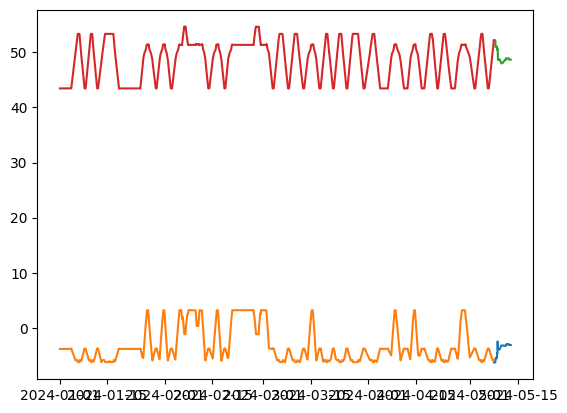

In [26]:
vessel = test_df['vesselId'].unique()[110]



vessel_data_test = test_df[test_df['vesselId'] == vessel]

vessel_data_train = train_df[train_df['vesselId'] == vessel]

plt.plot(vessel_data_test['time'],vessel_data_test['longitude_predicted'])

plt.plot(vessel_data_train['time'],vessel_data_train['longitude'])



plt.plot(vessel_data_test['time'],vessel_data_test['latitude_predicted'])

plt.plot(vessel_data_train['time'],vessel_data_train['latitude'])